# Burger equation in 1D (PINN & SPINN)

We solve the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (initial condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example.

To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns. We see that, without any specific tuning the SPINN offers an important gain in speed and precision of the solution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

2024-03-04 10:45:10.522450: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN

In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 1]
]
key, subkey = random.split(key)
u_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

Create the SPINN

In [6]:
d = 2
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r]
]
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

In [7]:
init_nn_params_pinn = u_pinn.init_params()
init_nn_params_spinn = u_spinn.init_params()

Create a DataGenerator object.

In [8]:
n = 1000
nt = 1000
nb = 2
omega_batch_size = 100
temporal_batch_size = 100
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

Note that the train_data_spinn DataGenerator will not output cartesian product of space and time collocation points.

In [ ]:
train_data_spinn = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method,
    cartesian_product=False
)

Let's plot the initial condition

## Model parameters

In [9]:
nu = 1 / (100 * jnp.pi)

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [10]:
init_params_pinn = {
    "nn_params":init_nn_params_pinn,
    "eq_params":{
        "nu":nu
    }
}
init_params_spinn = {
    "nn_params":init_nn_params_spinn,
    "eq_params":{
        "nu":nu
    }
}

## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

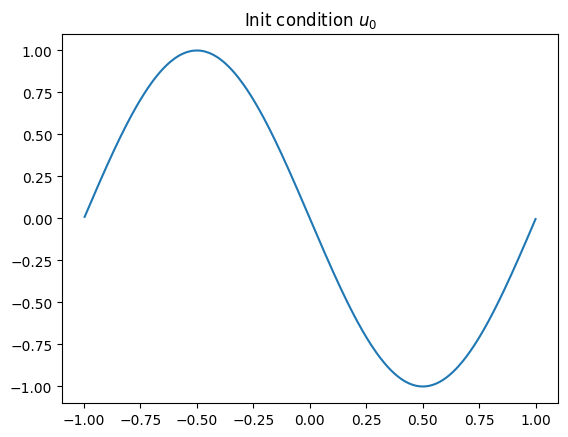

In [11]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Loss construction

In [12]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax)
loss_weights = {"dyn_loss":1, "initial_condition":100, "boundary_loss":1}

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0
)

In [13]:
loss_weights = {"dyn_loss":1, "initial_condition":10, "boundary_loss":1}

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

### Train the PINN and plot loss values and solution

In [14]:
params_pinn = init_params_pinn
import optax
tx = optax.adamw(learning_rate=1e-3)
n_iter = 30000
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter
)

  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 0: loss value = 48.214290618896484
Iteration 1000: loss value = 0.37082821130752563
Iteration 2000: loss value = 0.2846727669239044
Iteration 3000: loss value = 0.21062436699867249
Iteration 4000: loss value = 0.2939226031303406
Iteration 5000: loss value = 0.24167285859584808
Iteration 6000: loss value = 0.2206270396709442
Iteration 7000: loss value = 0.12375278770923615
Iteration 8000: loss value = 0.2117370218038559
Iteration 9000: loss value = 0.07597440481185913
Iteration 10000: loss value = 0.07032964378595352
Iteration 11000: loss value = 0.04097352176904678
Iteration 12000: loss value = 0.01825050264596939
Iteration 13000: loss value = 0.01395990327000618
Iteration 14000: loss value = 0.01533149927854538
Iteration 15000: loss value = 0.04685555025935173
Iteration 16000: loss value = 0.04617606848478317
Iteration 17000: loss value = 0.017959337681531906
Iteration 18000: loss value = 0.006106134969741106
Iteration 19000: loss value = 0.004953676834702492
Iteration 20000

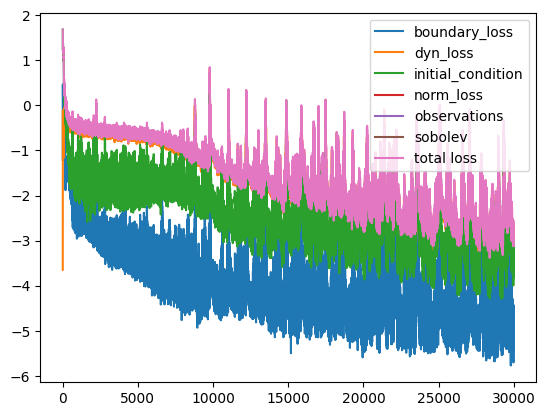

In [15]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

In [16]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

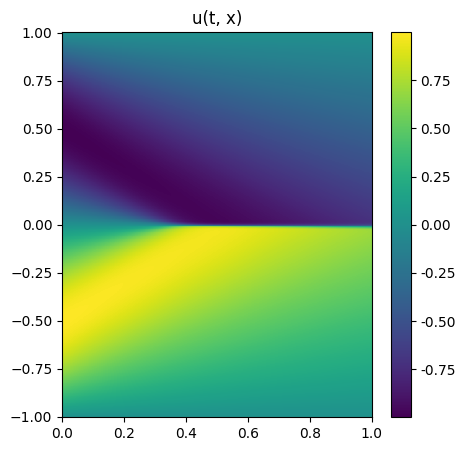

In [19]:
u_est_pinn = lambda t, x:u_pinn(t, x, params_pinn["nn_params"])
# same subkey
jinns.data.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)")

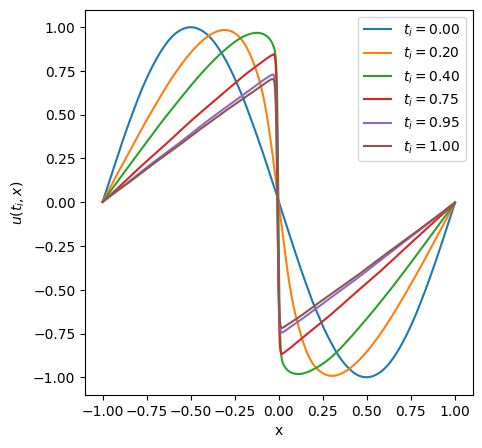

In [20]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.data.plot1d_slice(u_est_pinn, xdata=val_xdata, time_slices=time_slices,  figsize=(5, 5))

### Train the SPINN and plot loss values and solution

In [28]:
params_spinn = init_params_spinn
import optax
tx = optax.adamw(learning_rate=1e-4)
n_iter = 30000
params_spinn, total_loss_list_spinn, loss_by_term_dict_spinn, _, _, _, _ = jinns.solve(
    init_params=params_spinn,
    data=train_data_spinn,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter
)

Iteration 0: loss value = 4.958347320556641


  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 1000: loss value = 0.3678991496562958
Iteration 2000: loss value = 0.29296717047691345
Iteration 3000: loss value = 0.21614888310432434
Iteration 4000: loss value = 0.2792867422103882
Iteration 5000: loss value = 0.2441725730895996
Iteration 6000: loss value = 0.24313467741012573
Iteration 7000: loss value = 0.1580703854560852
Iteration 8000: loss value = 0.22208553552627563
Iteration 9000: loss value = 0.2204149067401886
Iteration 10000: loss value = 0.2021247148513794
Iteration 11000: loss value = 0.21286408603191376
Iteration 12000: loss value = 0.1905040144920349
Iteration 13000: loss value = 0.18884117901325226
Iteration 14000: loss value = 0.17063388228416443
Iteration 15000: loss value = 0.2179834097623825
Iteration 16000: loss value = 0.15261316299438477
Iteration 17000: loss value = 0.12258627265691757
Iteration 18000: loss value = 0.09361669421195984
Iteration 19000: loss value = 0.12204871326684952
Iteration 20000: loss value = 0.06250322610139847
Iteration 21000: 

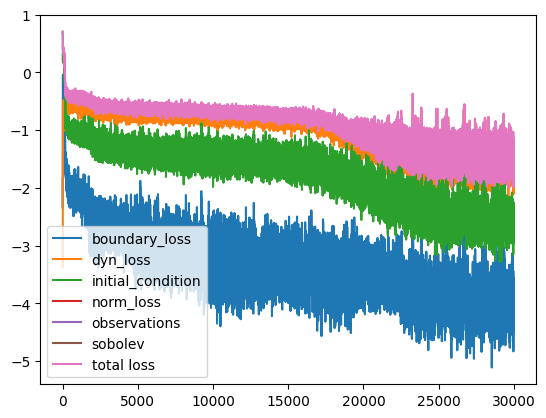

In [29]:
for loss_name, loss_values in loss_by_term_dict_spinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_spinn), label="total loss")
plt.legend()
plt.show()

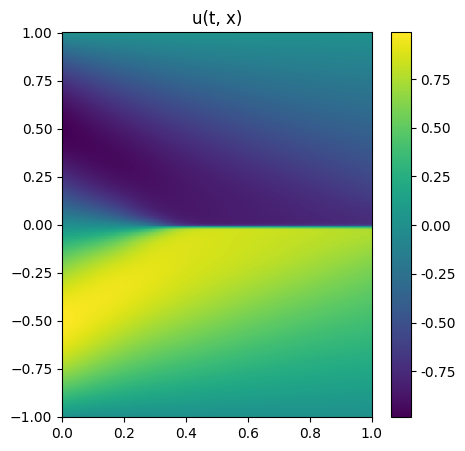

In [30]:
u_est_spinn = lambda t, x:u_spinn(t, x, params_spinn["nn_params"])

jinns.data.plot1d_image(u_est_spinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="u(t, x)", spinn=True)

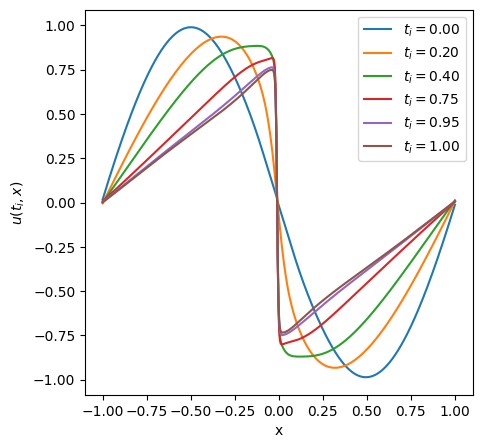

In [31]:
time_slices = [0, 0.2, 0.4, 0.75, 0.95, 1.]
jinns.data.plot1d_slice(u_est_spinn, xdata=val_xdata, time_slices=time_slices, spinn=True,  figsize=(5, 5))

## Conclusion

We have been able to solve the Burger PDE with jinns both with a PINN and SPINN. Given the same number of iterations, the PINN solution looks more accurate, but the SPINN solution is obtained approximately 10 times faster:

- PINN's progress bar: 30000/30000 [10:40<00:00, 47.08it/s]
 
- SPINN's progress bar: 30000/30000 [00:52<00:00, 573.94it/s]

(Times obtained on GPU Nvidia T600)

One could still improve SPINN's solution by tuning the network architecture and batch size as we here used default parameters. Since SPINNs are fast, one could also afford more iterations, possibly by finetuning with LBFGS.

## Other

Save the estimated solution grid values

In [ ]:
# x = test_data.omega.sort(axis=0).squeeze()
# t = test_data.times.sort(axis=0).squeeze()
# tv, xv = jnp.meshgrid(t, x)
# jnp.save("burger_t_grid.npy", tv)
# jnp.save("burger_x_grid.npy", xv)

# values = u_est_fp(tv.reshape((nt * n, 1)), xv.reshape((nt * n, 1)))
# grid = values.reshape(n, nt)
# jnp.save("burger_solution_grid.npy",
#     jnp.stack(
#         [tv, xv, grid],
#         axis=-1
#     )
# )
